In [1]:
import numpy as np
from project import Projection
from Problem import Problem
from main import run_experiment, load_config
from Phase1 import solve_CQ_feasible
from Phase2_1_obj import optim_Universal
from utils import visualize_pareto_front

In [2]:
import autograd.numpy as np
from autograd import jacobian
from scipy.optimize import Bounds
import matplotlib.pyplot as plt
import pandas as pd
import math

# Prob

In [3]:
def f(x):
    return np.array([
        4*x[0]**2 + 4*x[1]**2,
        (x[0] - 5)**2 + (x[1] - 5)**2
    ])


#--------------- C --------------------#
def c1(x):
    return -(x[0] - 5)**2 - x[1]**2 + 25
def c2(x):
    return -(x[0] - 8)**2 - (x[1] + 3)**2 + 17.7


#--------------- Q --------------------#
def q1(y):
    return 50**2 - (y[0] - 50)**2 - (y[1] - 50)**2

def q_plus(y):
    center = 50.0
    radius_sq = 50**2  
    
    dx = np.maximum(0, y[0] - center)
    dy = np.maximum(0, y[1] - center)
    return radius_sq - (dx**2 + dy**2)

# Hàm dùng cho Projection 
cons_C = (
    {
        'type': 'ineq', 'fun' : c1,     
    },
    {
        'type': 'ineq', 'fun' : c2,     
    }
)

dim_x = 2
bounds_x = Bounds([-15,-15],[30, 30])

cons_Q = (
    {
        'type': 'ineq', 'fun' : q1,     
    },    
)

cons_Qplus = (
    {'type': 'ineq', 'fun': q_plus},
)
dim_y = 2

In [36]:
# Setup Projections
proj_C_handler = Projection(cons=cons_C, bounds=bounds_x, dim=dim_x, proj_type='euclid')
proj_Q_handler = Projection(cons=cons_Q, bounds=None, dim=dim_y, proj_type='qplus')

# Setup Problem
prob = Problem(
    f=[f], jac_f=[jacobian(f)], C=[c1, c2], Q=[], 
    dim_x=dim_x, dim_y=dim_y,
    proj_C=proj_C_handler.project,
    proj_Qplus=proj_Q_handler.project
)

In [5]:
cfg = load_config()
x_feasible, x_hist_p1, f_hist_p1, z_proj_hist = solve_CQ_feasible(
    f=prob.objective_func,
    jac_f=prob.jacobian,
    proj_C=prob.proj_C,
    proj_Qplus=prob.proj_Qplus,
    x0=cfg['initialization']['x_init'],
    gamma=cfg['phase1']['gamma'], 
    max_iter=cfg['phase1']['max_iter'],
    tol=cfg['phase1']['tol']
)
print(f"-> Điểm khả thi (Feasible Point): {x_feasible}")

  2%|▏         | 1/50 [00:00<00:00, 95.58it/s]


Hội tụ tại vòng lặp 1
-> Điểm khả thi (Feasible Point): [ 3.83455758 -2.40916209]


In [6]:
x_final, path_x = optim_Universal(
    prob=prob,
    x_feasible=x_feasible,  
    r=None,
    target_dim=1,
    mode='min',
    max_iter=cfg['phase2']['max_iter'],
    mu=cfg['phase2']['mu'],
    expo_alpha=cfg['phase2']['expo_alpha'],
    expo_lambda=cfg['phase2']['expo_lambda'],
    init_params=cfg['phase2']['init_params']
)

In [7]:
mode_run = ["min"]
dim_run = [0, 1]

limit_Q = []
for mode in mode_run:
    for dim in dim_run:
        x_final, _ = optim_Universal(
                prob=prob,
                x_feasible=x_feasible,  
                r=None,
                target_dim=dim,
                mode=mode,
                max_iter=cfg['phase2']['max_iter'],
                mu=cfg['phase2']['mu'],
                expo_alpha=cfg['phase2']['expo_alpha'],
                expo_lambda=cfg['phase2']['expo_lambda'],
                init_params=cfg['phase2']['init_params']
            )
        limit_Q.append(f(x_final)[dim])

In [8]:
min_x, min_y = limit_Q
limit_Q

[np.float64(75.23575794580822), np.float64(25.502042713213225)]

# Gen

## Rays

In [9]:
num_rays = 25 # = số nghiệm

In [17]:
def generate_chebyshev_rays(num_rays=10):
    """
    Sinh ra danh sách các vector trọng số r bằng cách quét góc từ 0 đến 90 độ.

    """
    rays = []
    
    # Quét góc từ 0 đến 90 độ (0 đến pi/2 radian)
    angles = np.linspace(0, np.pi/2, num_rays)
    
    for theta in angles:

        r1 = math.cos(theta)
        r2 = math.sin(theta)

        if abs(r1) < 1e-9: r1 = 0.0
        if abs(r2) < 1e-9: r2 = 0.0
            
        r = [r1, r2]
        
        rays.append(r)       
    return np.array(rays)

In [11]:
np.array(limit_Q)

array([75.23575795, 25.50204271])

In [12]:
# Gốc tọa độ mới (z*)
z_star = np.array([min_x, min_y])
transformer = CoordinateTransformer(z_star)

list_r = generate_chebyshev_rays(num_rays=25)

print(f"Gốc tọa độ mới (Ideal Point): {z_star}\n")
print("Các vector r sinh ra:")
for i, r in enumerate(list_r):
    print(f"Ray {i+1}: {r}")

Gốc tọa độ mới (Ideal Point): [75.23575795 25.50204271]

Các vector r sinh ra:
Ray 1: [1. 0.]
Ray 2: [0.99785892 0.06540313]
Ray 3: [0.99144486 0.13052619]
Ray 4: [0.98078528 0.19509032]
Ray 5: [0.96592583 0.25881905]
Ray 6: [0.94693013 0.32143947]
Ray 7: [0.92387953 0.38268343]
Ray 8: [0.89687274 0.44228869]
Ray 9: [0.8660254 0.5      ]
Ray 10: [0.83146961 0.55557023]
Ray 11: [0.79335334 0.60876143]
Ray 12: [0.75183981 0.65934582]
Ray 13: [0.70710678 0.70710678]
Ray 14: [0.65934582 0.75183981]
Ray 15: [0.60876143 0.79335334]
Ray 16: [0.55557023 0.83146961]
Ray 17: [0.5       0.8660254]
Ray 18: [0.44228869 0.89687274]
Ray 19: [0.38268343 0.92387953]
Ray 20: [0.32143947 0.94693013]
Ray 21: [0.25881905 0.96592583]
Ray 22: [0.19509032 0.98078528]
Ray 23: [0.13052619 0.99144486]
Ray 24: [0.06540313 0.99785892]
Ray 25: [0. 1.]


## Cloud

In [40]:
def generate_pareto_grid(resolution=300):
    """
    Sinh dữ liệu bằng cách quét lưới tọa độ (Grid Search).
    resolution: Số điểm chia trên mỗi trục (càng lớn càng mịn nhưng càng chậm).
    """
    print(f"Đang quét lưới {resolution}x{resolution} = {resolution**2} điểm...")
    
    # 1. Xác định phạm vi quét (Dựa trên giao của 2 hình tròn C1 và C2)
    # C1: Tâm(5, 0), R=5 -> x[0, 10], y[-5, 5]
    # C2: Tâm(8, -3), R~4.2
    # -> Chọn vùng bao phủ vừa đủ để code chạy nhanh
    x_range = np.linspace(0, 10, resolution) 
    y_range = np.linspace(-5, 5, resolution)

    pf_cloud_list = []

    # 2. Vét cạn (Nested Loops như mẫu của bạn)
    for x1 in x_range:
        for x2 in y_range:
            tmp_x = np.array([x1, x2])
            
            # Kiểm tra ràng buộc tập C (Decision Space Constraints)
            # Lưu ý: Bài toán định nghĩa c >= 0
            if (c1(tmp_x) >= 0 and 
                c2(tmp_x) >= 0):
                
                # Tính giá trị mục tiêu
                f_val = f(tmp_x)
                
                # Kiểm tra ràng buộc tập Q (Objective Space Constraints)
                if q1(f_val) >= 0:
                    pf_cloud_list.append(f_val)

    if len(pf_cloud_list) == 0:
        print("Vẫn không tìm thấy điểm nào. Hãy kiểm tra lại hàm ràng buộc hoặc nới rộng vùng quét.")
        return None, None

    # Chuyển sang numpy array
    pf_cloud_data = np.array(pf_cloud_list)
    print(f"-> Tìm thấy {len(pf_cloud_data)} điểm khả thi (Cloud).")

    # 3. Lọc Pareto Front (Targets) từ Cloud
    # Sắp xếp theo f1 tăng dần
    sorted_indices = np.argsort(pf_cloud_data[:, 0])
    y_sorted = pf_cloud_data[sorted_indices]
    
    pareto_list = []
    if len(y_sorted) > 0:
        # Điểm đầu tiên chắc chắn là Pareto
        pareto_list.append(y_sorted[0])
        current_min_f2 = y_sorted[0][1]
        
        # Duyệt để tìm các điểm không bị trội
        for i in range(1, len(y_sorted)):
            if y_sorted[i][1] < current_min_f2:
                pareto_list.append(y_sorted[i])
                current_min_f2 = y_sorted[i][1]
    
    pf_targets_data = np.array(pareto_list)
    print(f"-> Lọc được {len(pf_targets_data)} điểm Pareto chuẩn.")
    
    return pf_cloud_data, pf_targets_data

In [46]:
# Sinh dữ liệu
pf_cloud, pf_targets = generate_pareto_grid(resolution=600)

Đang quét lưới 600x600 = 360000 điểm...
-> Tìm thấy 4940 điểm khả thi (Cloud).
-> Lọc được 46 điểm Pareto chuẩn.


# Solve

In [13]:
results = run_experiment(prob)

=== BẮT ĐẦU PHASE 1: TÌM ĐIỂM KHẢ THI ===


  2%|▏         | 1/50 [00:00<00:00, 97.31it/s]


Hội tụ tại vòng lặp 1
-> Điểm khả thi (Feasible Point): [ 3.83455797 -2.40915934]
=== TÌM GIỚI HẠN PARETO: OPTIM 1 OBJ CỦA F ===


Chiều 0: 75.23575590661365
Chiều 1: 25.44280239248419

=== BẮT ĐẦU PHASE 2: SCALARIZATION (MULTI-RAY) ===
Running Ray 1/25: [1. 0.]
Running Ray 2/25: [0.99785892 0.06540313]
Running Ray 3/25: [0.99144486 0.13052619]
Running Ray 4/25: [0.98078528 0.19509032]
Running Ray 5/25: [0.96592583 0.25881905]
Running Ray 6/25: [0.94693013 0.32143947]
Running Ray 7/25: [0.92387953 0.38268343]
Running Ray 8/25: [0.89687274 0.44228869]
Running Ray 9/25: [0.8660254 0.5      ]
Running Ray 10/25: [0.83146961 0.55557023]
Running Ray 11/25: [0.79335334 0.60876143]
Running Ray 12/25: [0.75183981 0.65934582]
Running Ray 13/25: [0.70710678 0.70710678]
Running Ray 14/25: [0.65934582 0.75183981]
Running Ray 15/25: [0.60876143 0.79335334]
Running Ray 16/25: [0.55557023 0.83146961]
Running Ray 17/25: [0.5       0.8660254]
Running Ray 18/25: [0.44228869 0.89687274]
Running Ray 19/25: [0.38268343 0.92387953]
Running Ray 20/25: [0.32143947 0.94693013]
Running Ray 21/25: [0.25881905 0.96592583]
Running Ray 22/25: [

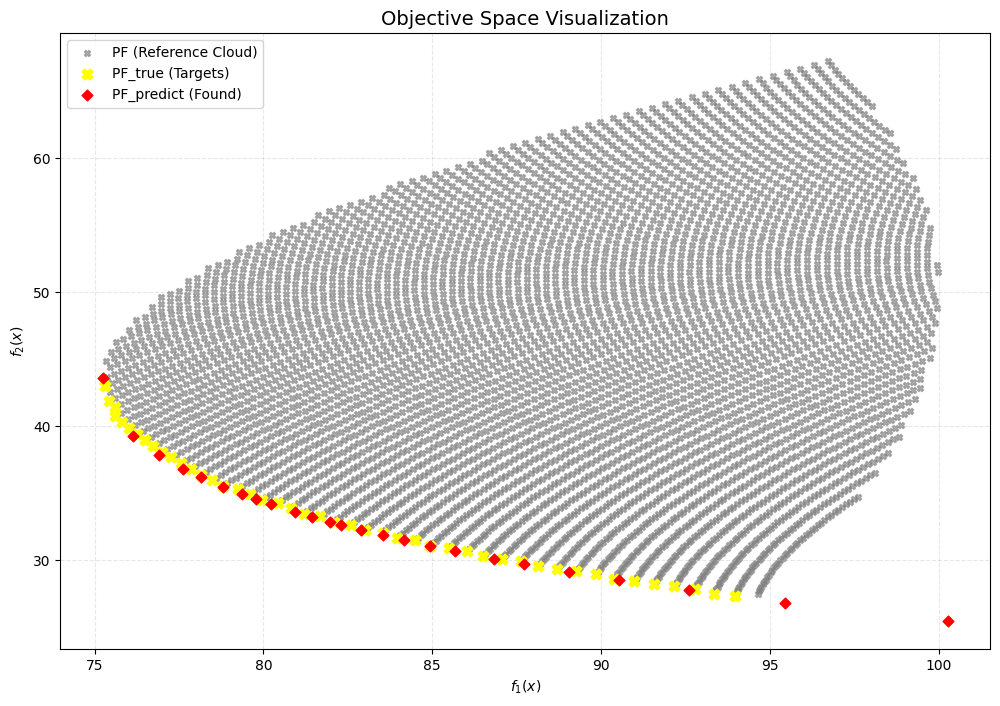

In [47]:
visualize_pareto_front(
    pf_pred=results["pareto_f"], 
    pf_cloud=pf_cloud,   
    pf_targets=pf_targets,
    title="Objective Space Visualization",
    figsize=(12, 8)
)

# Write

In [26]:
from ruamel.yaml import YAML
from ruamel.yaml.comments import CommentedSeq

In [28]:

# 3. Khởi tạo đối tượng YAML để giữ format và comment
yaml = YAML()
yaml.preserve_quotes = True
yaml.indent(mapping=2, sequence=4, offset=2) # Căn chỉnh lề cho đẹp

# 4. Đọc file config hiện tại
config_file = 'config.yaml'

try:
    with open(config_file, 'r', encoding='utf-8') as f:
        data = yaml.load(f)
except FileNotFoundError:
    print(f"Không tìm thấy file {config_file}, hãy tạo file mẫu trước.")
    exit()

# 5. Chuyển đổi dữ liệu Numpy sang định dạng YAML list chuẩn
#    Lưu ý: YAML không hiểu numpy.float, phải chuyển về float thường
yaml_rays = CommentedSeq()

for r in list_r:
    # Tạo list con [x, y]
    # Dùng float() để convert từ numpy float64
    item = CommentedSeq([float(r[0]), float(r[1])])
    
    # Quan trọng: Thiết lập flow_style=True để nó ra dạng [x, y] nằm ngang
    item.fa.set_flow_style() 
    
    yaml_rays.append(item)

# 6. Gán dữ liệu mới vào cấu trúc config
if 'data' not in data:
    data['data'] = {}

data['data']['test_ray'] = yaml_rays

# 7. Ghi đè lại vào file config.yaml
with open(config_file, 'w', encoding='utf-8') as f:
    yaml.dump(data, f)

print(f"Đã cập nhật {len(list_r)} tia mới vào file {config_file} thành công!")

Đã cập nhật 25 tia mới vào file config.yaml thành công!
